<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Marfida%20Alexander/Staj_profpatolog_4_(%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%2B%D0%B1%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B9%2B3_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B0_%D0%BF%D0%BE_%D0%A2%D0%97).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Стажировка. Профпатолог (INSPECTRUM CLINIC)
- Модели обучения для категориальных данных с удалением строк с NaN в целевом столбце "ЗаключениеМК" и балансировкой датасета
- Целевые категории:
  - Годен
  - Не годен
  - Ограниченно годен

# ЗАГРУЗКА БИБЛИОТЕК И ДАТАСЕТОВ

In [ ]:
# Подключение библиотек

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Предварительная обработка данных
# from sklearn import preprocessing

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Связь с google-диском
from google.colab import files

# Отрисовка графиков
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Создание статистических графиков
import seaborn as sns

# Табличные данные
from fastai.tabular import *

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Разделение данных на выборки
from sklearn.model_selection import train_test_split

# Очистка экрана
from IPython.display import clear_output

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [ ]:
# Монтирование Goodle-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# СЛУЖЕБНЫЕ ФУНКЦИИ

Загрузка датасетов

In [ ]:
x_train_norm_0b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/x_train_norm_0b.npy')
x_train_ohe_0b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/x_train_ohe_0b.npy')
y_train_norm_0b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/y_train_norm_0b.npy')
y_train_ohe_0b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/y_train_ohe_0b.npy')

print(x_train_norm_0b.shape)
print(y_train_norm_0b.shape)
print(x_train_ohe_0b.shape)
print(y_train_ohe_0b.shape)

(4509, 69)
(4509, 1)
(4509, 1987)
(4509, 3)


## Функция графиков обучения

In [ ]:
def graphic(loss, accuracy, valloss, valaccuracy, scor, scorloss, exp, param):

  print(
    f'Входных Нейронов: {param[0]}\n',
    f'Значение Dropout: {param[1]}\n',
    f'BatchNormalization: {param[2]}\n',
    f'Средние потери: {param[3]}\n',
    f'Средняя точность на тестовой выборке: {param[4]}\n'
  )
  print('↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓')


  plt.figure(1, figsize=(20, 5))

  plt.subplot(1, 2, 1)
  plt.plot(accuracy, label='Доля верных ответов(train)')
  plt.plot(valaccuracy, label='Доля верных ответов(val)')
#  plt.scatter(19, scor/100, c='r')
  plt.title(f'Опыт№ {exp+1}. Параметры модели: {param}')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.grid(color='gray', linestyle=':')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='train_loss')
  plt.plot(valloss, label='val_loss')
#  plt.scatter(19, scorloss, c='r')
  plt.title(f'Опыт№ {exp+1}, loss')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(color='gray',linestyle=':')
  print()
  plt.show()

## Функция создания модели

In [ ]:
def сreatModel(numN, drop, norm=False, layer2=0, layer3=0):
    # Создание последовательной модели
    model = Sequential()

    if norm:
        model.add(BatchNormalization(input_shape=(x_train.shape[1], )))
        model.add(Dense(numN, activation="relu"))
    else:
        model.add(Dense(numN, input_dim=x_train.shape[1], activation="relu"))

    if layer2 > 0:
      model.add(Dense(numN*layer2, input_dim=x_train.shape[1], activation="relu"))
    elif layer2 < 0:
      model.add(Dense(int(numN/(-layer2)), input_dim=x_train.shape[1], activation="relu"))

    if layer3 > 0:
      model.add(Dense(numN*layer2, input_dim=x_train.shape[1], activation="relu"))
    elif layer3 < 0:
      model.add(Dense(int(numN/(-layer2)), input_dim=x_train.shape[1], activation="relu"))

    model.add(Dropout(drop))
    model.add(Dense(3, activation="softmax")) #

    # Компиляция модели
    model.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
    return model

## Функция обучения и тестирования модели

In [ ]:
def training(dense_list, drop_list, norm_list, layer2=0, layer3=0):

  parameters = []
  val_accuracy= []
  val_loss_ = []
  accuracy= []
  loss_ = []

  for numN in dense_list:
    for norm in norm_list:
      for drop in drop_list:

        print('Параметры модели: вх.нейр.=', numN, '; откл.нейр.=', drop, '; BatchNormalization=', norm)

        # Создание последовательной модели
        model = сreatModel(numN, drop, norm=norm, layer2=layer2, layer3=layer3)

        # Обучение модели
        history = model.fit(x_train,    # обучающая выборка экземпляры класса
                  y_train,              # обучающая выборка метки класса
                  batch_size=128,       # размер батча
                  epochs=20,            # количество эпох
                  verbose=1,            # 0 - не показывать ход обучения, 1 - показывать
                  validation_data=(x_val, y_val) # выборка для валидации
                  )

        scores = model.evaluate(x_test, y_test)
        print('Точность на тестовой выборке:', scores[1] )

        parameters.append([numN, drop, norm, round(scores[0], 4), round(scores[1], 4)*100])
        val_accuracy.append(history.history['val_accuracy'])
        val_loss_.append(history.history['val_loss'])
        accuracy.append(history.history['accuracy'])
        loss_.append(history.history['loss'])

  return parameters, accuracy, loss_, val_accuracy, val_loss_

## Разделение на обучающую, валидационную и тестовую выборки

In [ ]:
X_tr_n = x_train_norm_0b
X_tr_o = x_train_ohe_0b
Y_tr_n = y_train_norm_0b
Y_tr_o = y_train_ohe_0b

In [ ]:
print('X_tr_o.shape = ', X_tr_o.shape)
print('Y_tr_o.shape = ', Y_tr_o.shape)
print()
train_sep = int(X_tr_n.shape[0] * 0.9)
x_train, x_test, y_train, y_test =  X_tr_o[:train_sep], X_tr_o[train_sep:], Y_tr_o[:train_sep], Y_tr_o[train_sep:]
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape', y_test.shape)
print()
val_sep = int(x_train.shape[0] * 0.8)
x_train, x_val, y_train, y_val = x_train[:val_sep], x_train[val_sep:], y_train[:val_sep], y_train[val_sep:]
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape', y_val.shape)


X_tr_o.shape =  (4509, 1987)
Y_tr_o.shape =  (4509, 3)

x_train.shape =  (4058, 1987)
y_train.shape =  (4058, 3)
x_test.shape =  (451, 1987)
y_test.shape (451, 3)

x_train.shape =  (3246, 1987)
y_train.shape =  (3246, 3)
x_val.shape =  (812, 1987)
y_val.shape (812, 3)


## Создание модели

In [ ]:
model1 = сreatModel(64, 0.1, True)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 69)               276       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                4480      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,016
Trainable params: 4,878
Non-trainable params: 138
_________________________________________________________________


In [ ]:
y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

### Списки гиперпараметров

In [ ]:
dense_param = [32, 64, 128, 256]             # кол-во нейронов во входном слое
drop_param  = [0.01, 0.25]        # доля отключаемых нейронов, слой Dropout
norm_param = [False, True]             # для BatchNormalization

## Обучение модели с одним слоем

In [ ]:
par, acc, loss, val_acc, val_loss = training(dense_param, drop_param, norm_param)

Параметры модели: вх.нейр.= 32 ; откл.нейр.= 0.01 ; BatchNormalization= False
Epoch 1/20
26/26 [==============================] - 1s 17ms/step - loss: 0.8339 - accuracy: 0.7942 - val_loss: 0.5197 - val_accuracy: 0.9249
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.3854 - accuracy: 0.9356 - val_loss: 0.2418 - val_accuracy: 0.9594
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1980 - accuracy: 0.9559 - val_loss: 0.1418 - val_accuracy: 0.9618
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1240 - accuracy: 0.9784 - val_loss: 0.0970 - val_accuracy: 0.9828
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0837 - accuracy: 0.9868 - val_loss: 0.0712 - val_accuracy: 0.9840
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.9938 - val_loss: 0.0542 - val_accuracy: 0.9877
Epoch 7/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0474 - 

In [ ]:
print(acc[1])
print(val_acc[1], '\n')
print(loss[1])
print(val_loss[1])

[0.7960566878318787, 0.9309920072555542, 0.968268632888794, 0.9747381210327148, 0.9870610237121582, 0.9929143786430359, 0.9944547414779663, 0.9950708746910095, 0.9969192743301392, 0.9966112375259399, 0.9966112375259399, 0.9981516003608704, 0.9981516003608704, 0.9984596371650696, 0.9978435039520264, 0.9981516003608704, 0.9978435039520264, 0.9990757703781128, 0.9987677335739136, 0.9984596371650696]
[0.935960590839386, 0.9593595862388611, 0.9802955389022827, 0.9839901328086853, 0.9852216839790344, 0.9950739145278931, 0.9963054060935974, 0.9963054060935974, 0.9975369572639465, 0.9975369572639465, 0.9975369572639465, 0.9975369572639465, 0.9987684488296509, 0.9987684488296509, 0.9975369572639465, 0.9987684488296509, 0.9987684488296509, 0.9987684488296509, 0.9987684488296509, 0.9987684488296509] 

[0.6984133720397949, 0.31330448389053345, 0.17226319015026093, 0.1217835322022438, 0.08744010329246521, 0.06572550535202026, 0.051405590027570724, 0.04033949226140976, 0.03450452908873558, 0.0290858

In [ ]:
par

[[32, 0.01, False, 0.024, 98.89],
 [32, 0.25, False, 0.0205, 99.33],
 [32, 0.01, True, 0.0172, 99.33],
 [32, 0.25, True, 0.0153, 99.33],
 [64, 0.01, False, 0.0169, 99.56],
 [64, 0.25, False, 0.014, 99.33],
 [64, 0.01, True, 0.016, 99.56],
 [64, 0.25, True, 0.014, 99.33],
 [128, 0.01, False, 0.0118, 99.78],
 [128, 0.25, False, 0.0154, 99.33],
 [128, 0.01, True, 0.0182, 99.11],
 [128, 0.25, True, 0.0174, 98.89],
 [256, 0.01, False, 0.0113, 99.56],
 [256, 0.25, False, 0.0099, 99.56],
 [256, 0.01, True, 0.0108, 99.56],
 [256, 0.25, True, 0.0124, 99.56]]

### Сводные результаты обучения

In [ ]:
col = [' Число Нейронов ', ' Значение Dropout ',' BatchNormalization? ',' Loss тестовой ', ' Точность тестовой ']
df = pd.DataFrame(par, columns = col, index= np.arange(1, len(par)+1))
df

,Число Нейронов,Значение Dropout,BatchNormalization?,Loss тестовой,Точность тестовой
1,32,0.01,False,0.0240,98.89
2,32,0.25,False,0.0205,99.33
3,32,0.01,True,0.0172,99.33
4,32,0.25,True,0.0153,99.33
5,64,0.01,False,0.0169,99.56
6,64,0.25,False,0.0140,99.33
7,64,0.01,True,0.0160,99.56
8,64,0.25,True,0.0140,99.33
9,128,0.01,False,0.0118,99.78
10,128,0.25,False,0.0154,99.33


### Графики обучения

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.024
 Средняя точность на тестовой выборке: 98.89

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



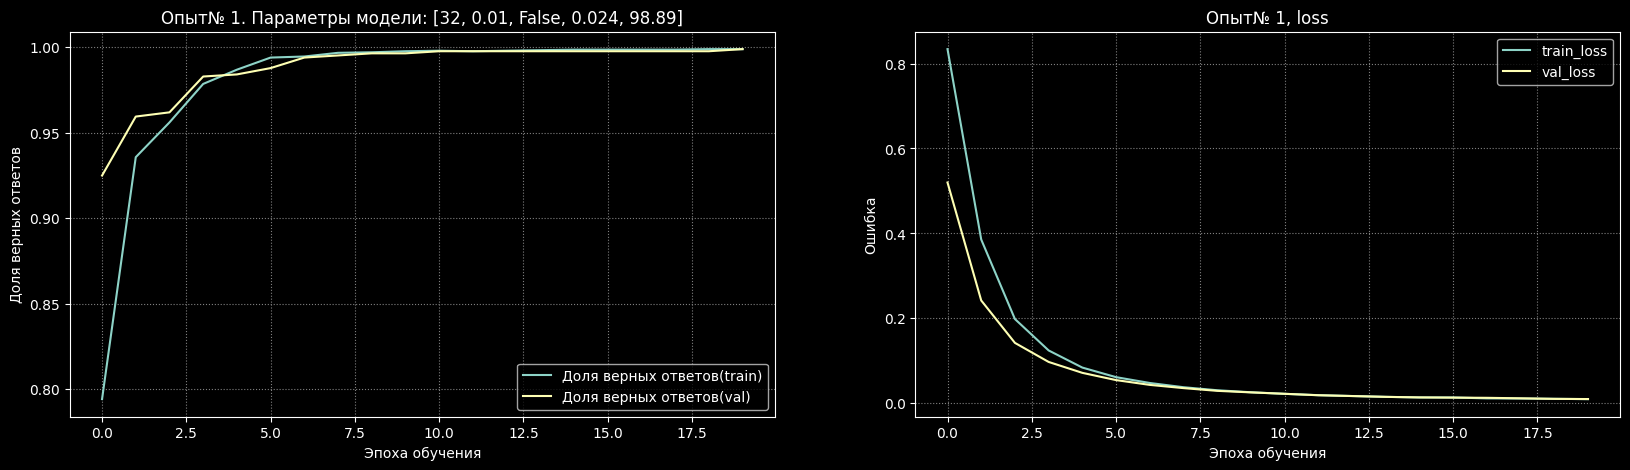

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0205
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



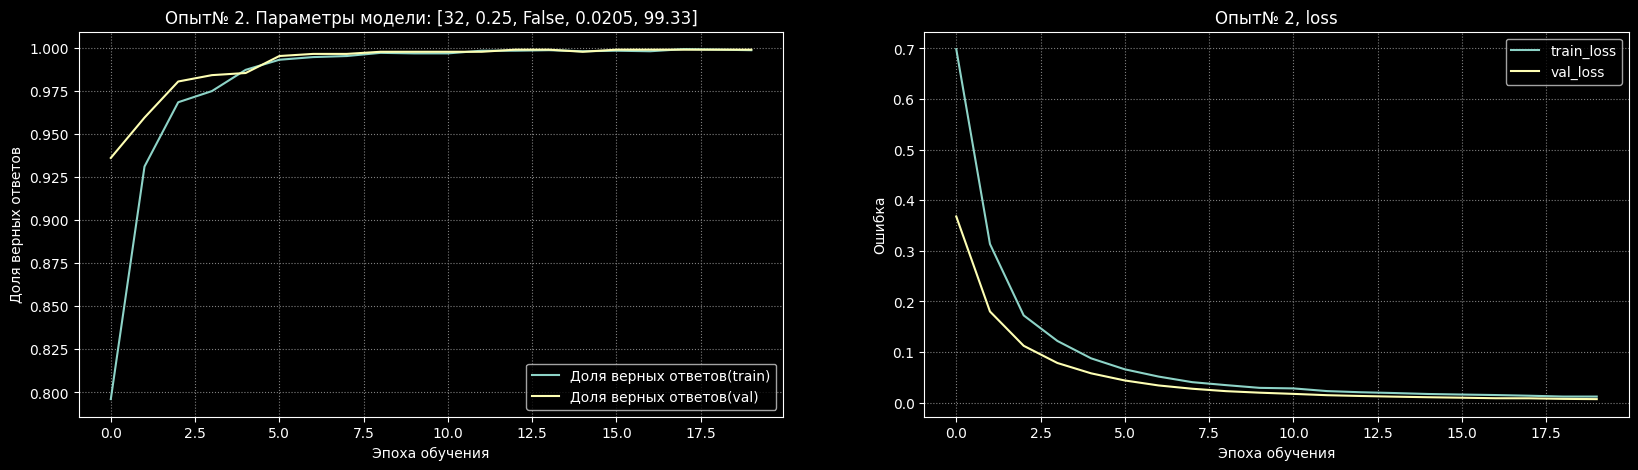

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0172
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



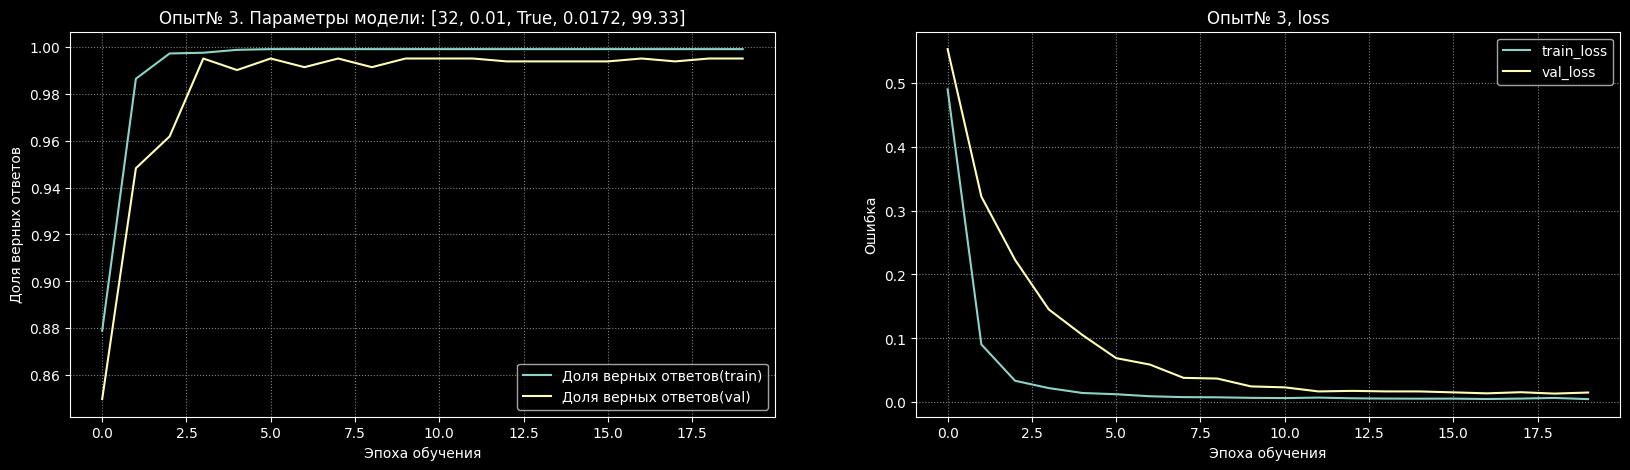

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0153
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



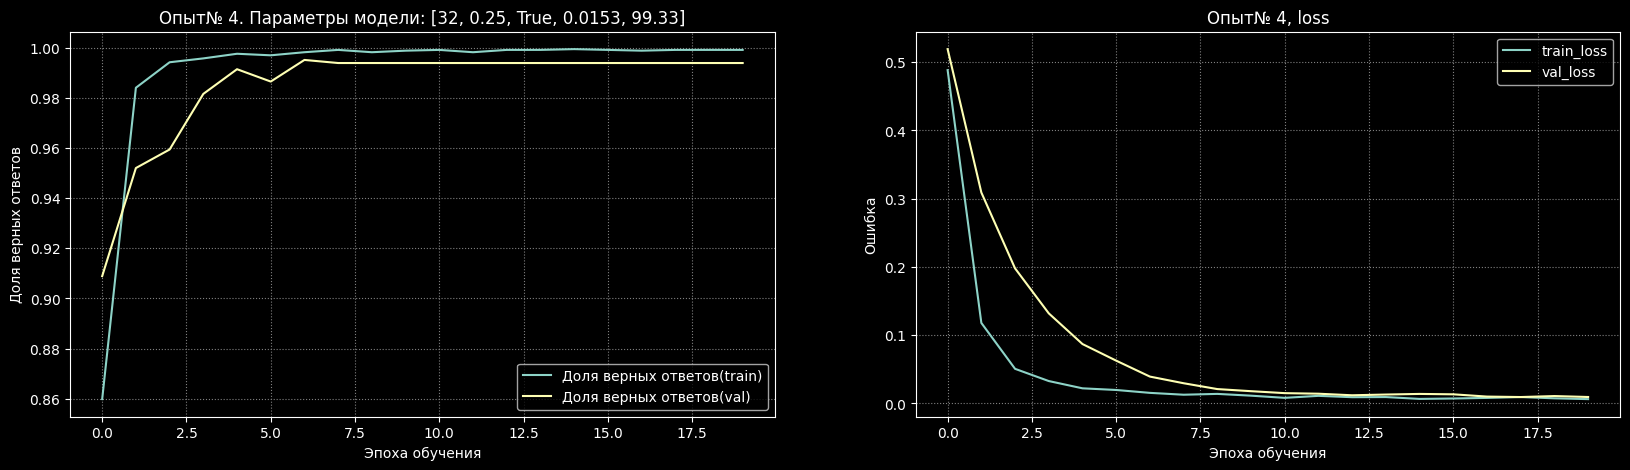

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0169
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



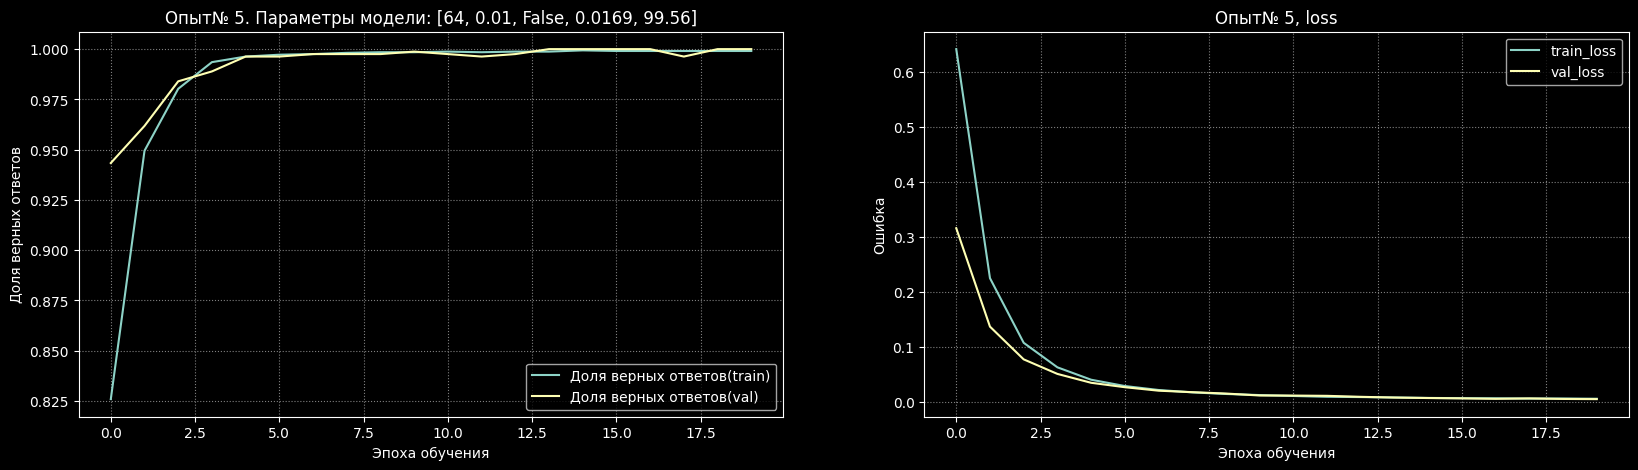

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.014
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



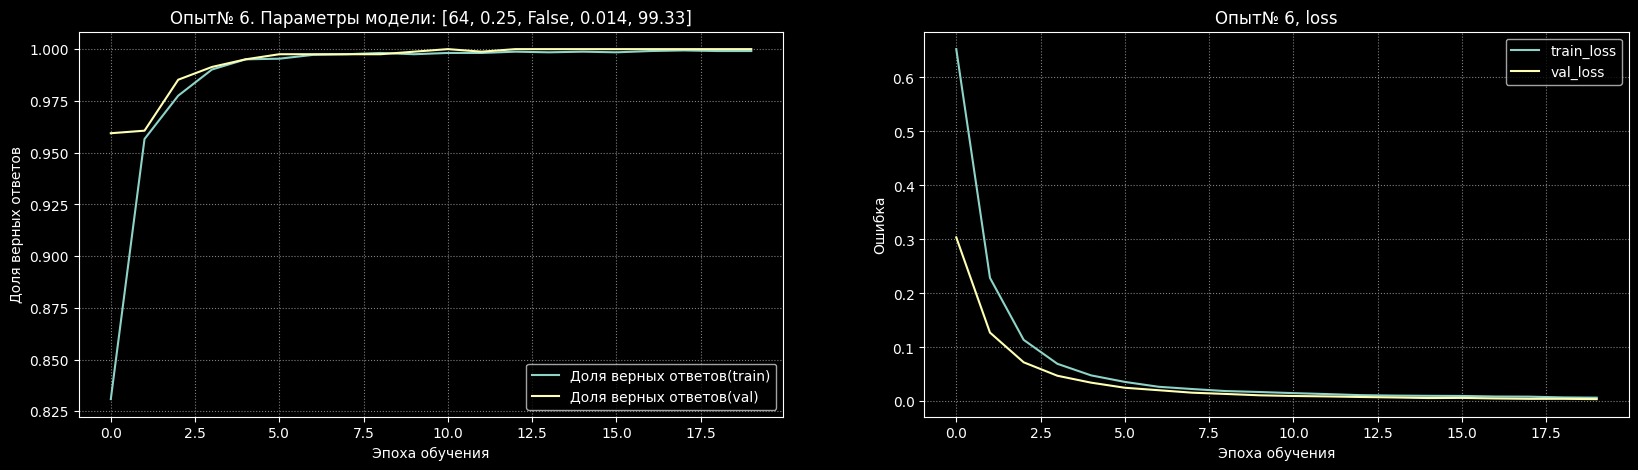

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.016
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



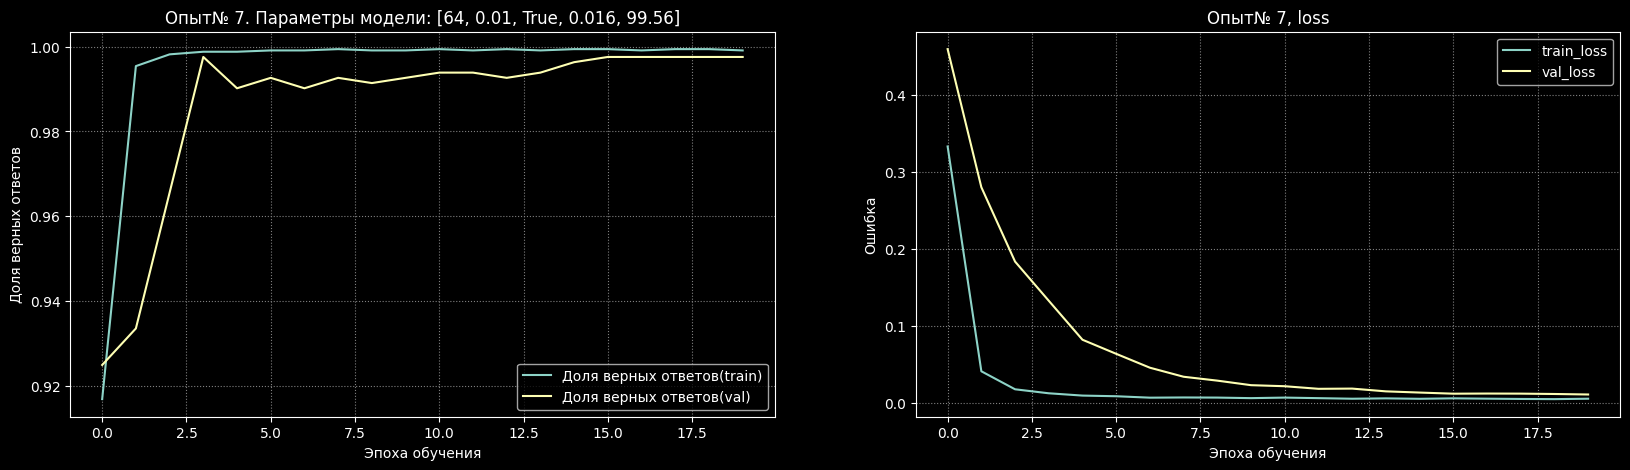

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.014
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



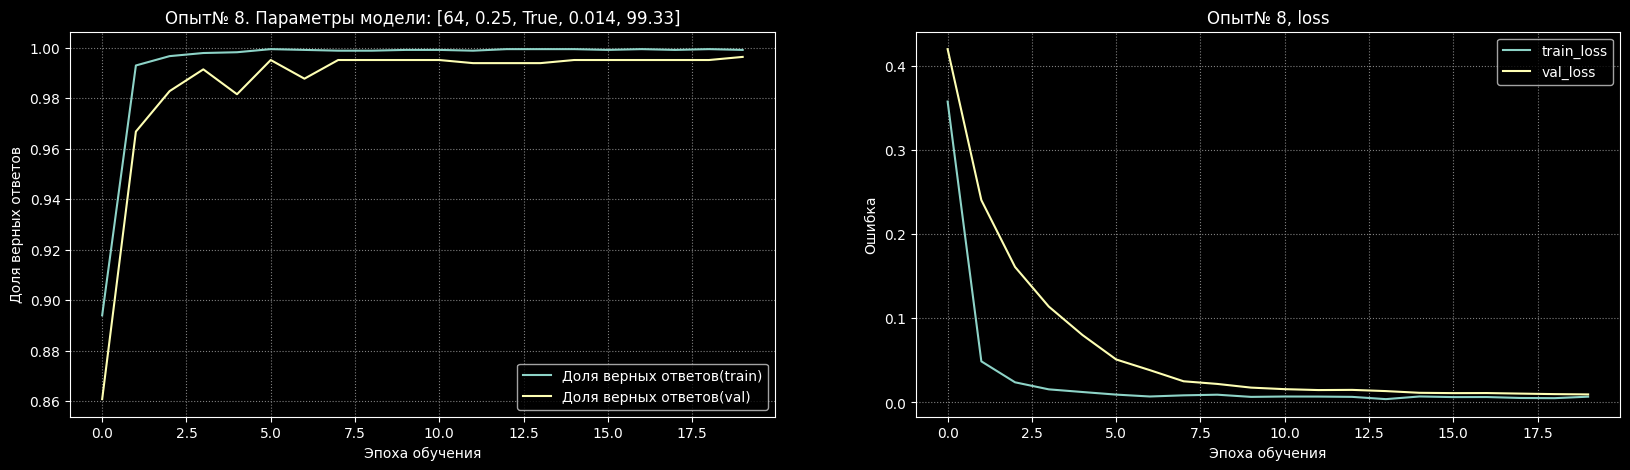

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0118
 Средняя точность на тестовой выборке: 99.78

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



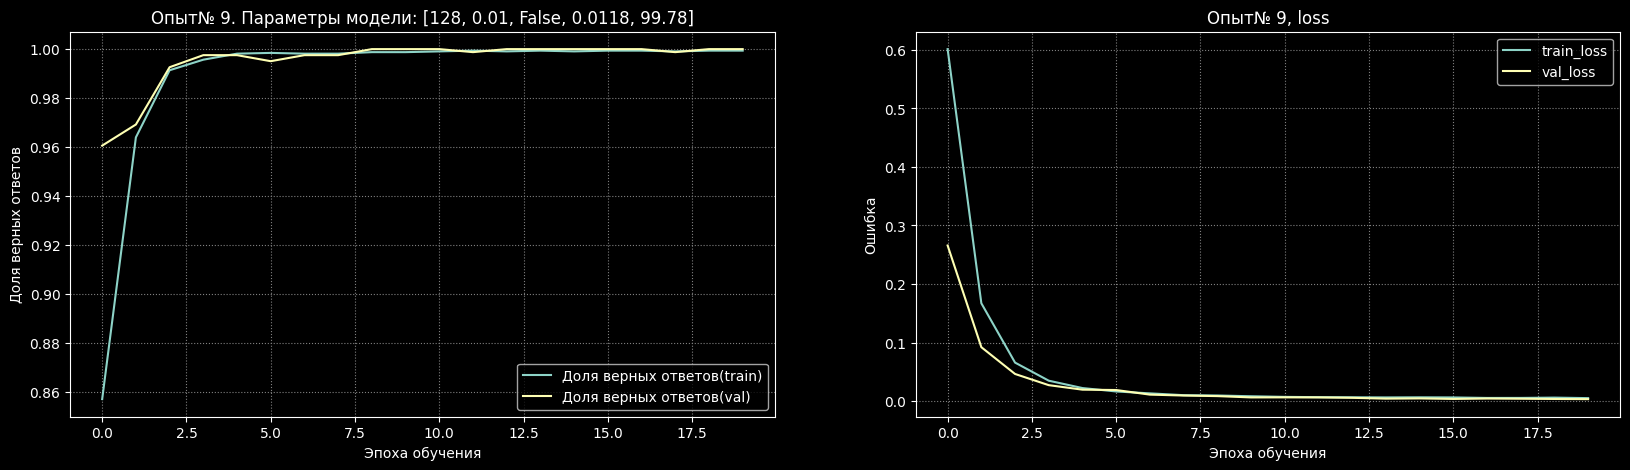

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0154
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



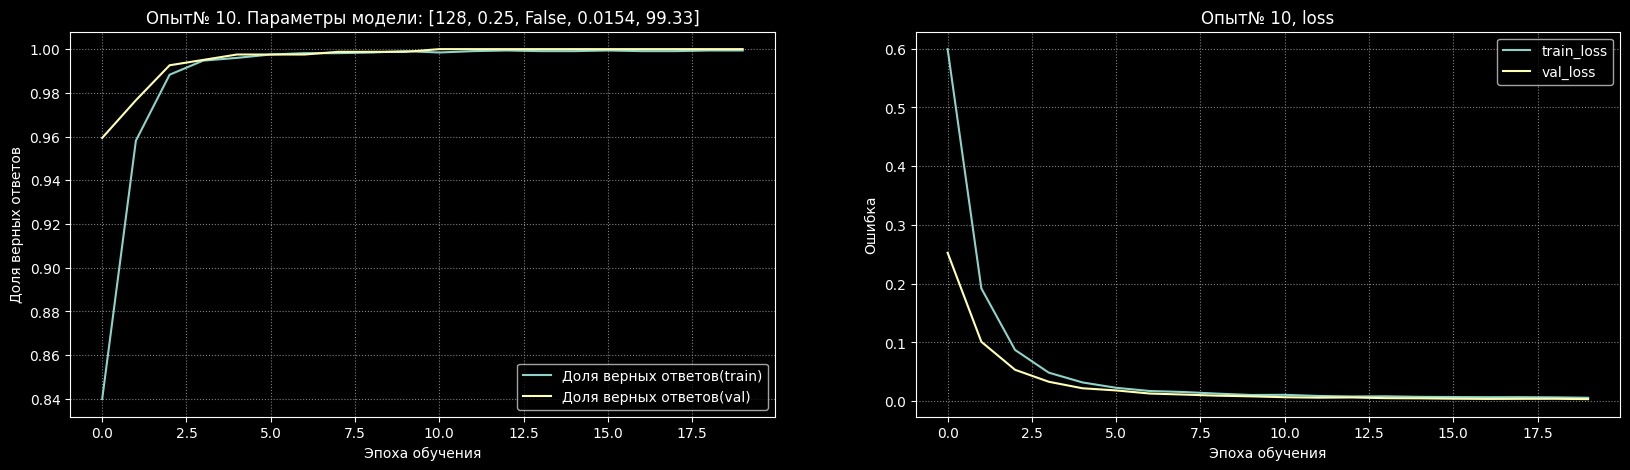

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0182
 Средняя точность на тестовой выборке: 99.11

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



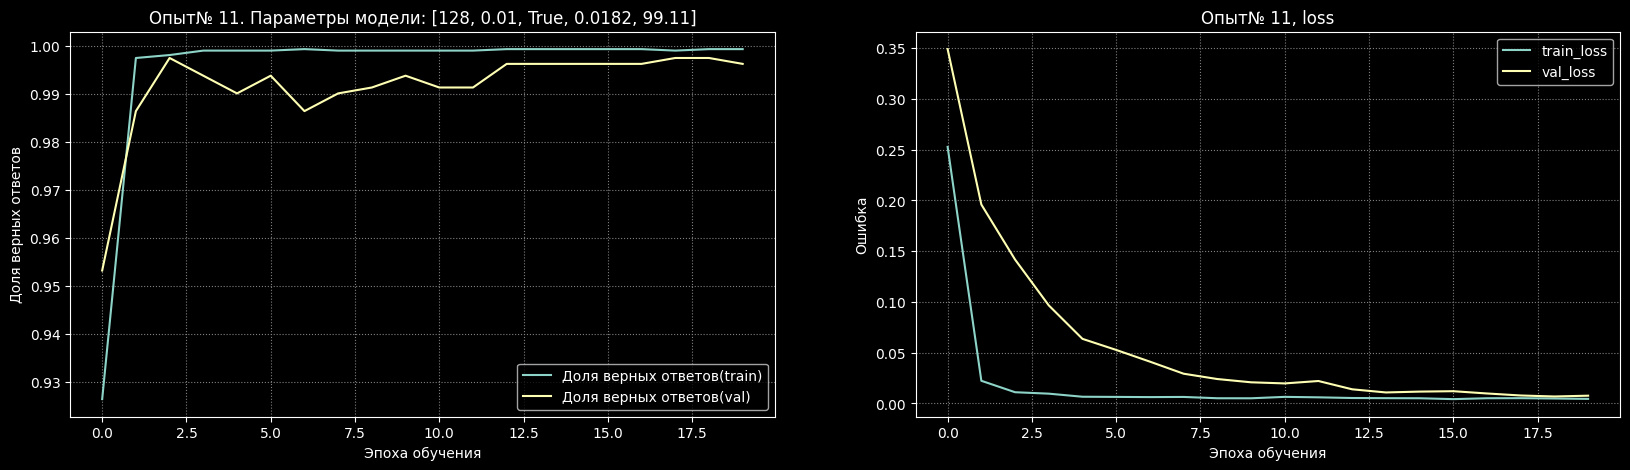

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0174
 Средняя точность на тестовой выборке: 98.89

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



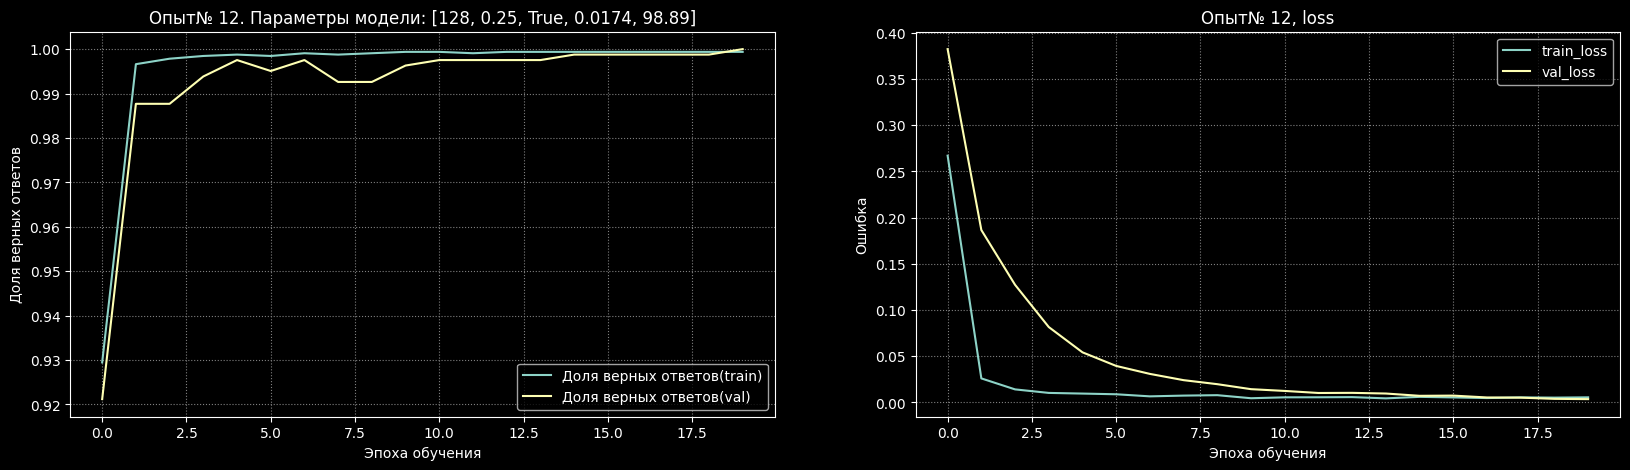

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0113
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



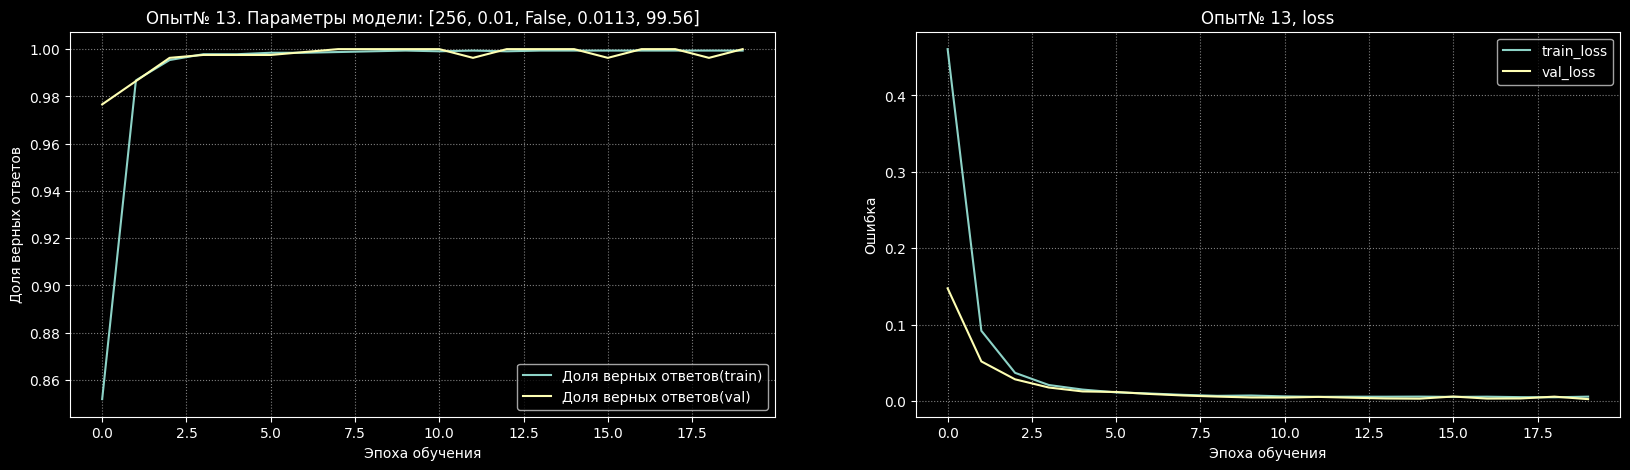

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0099
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



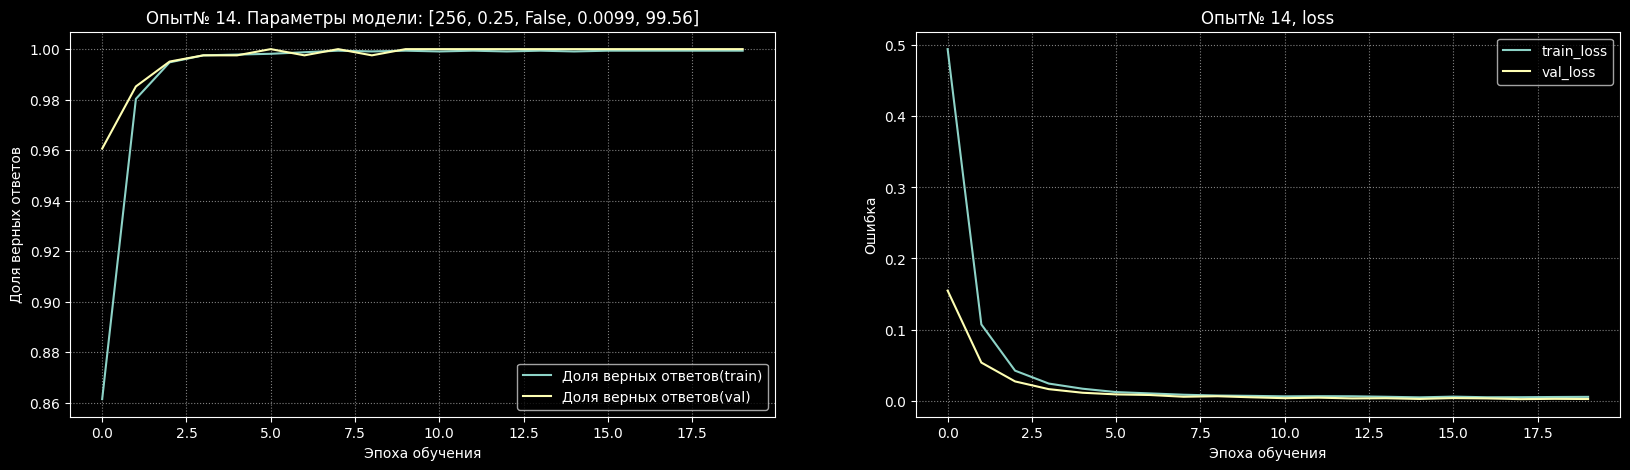

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0108
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



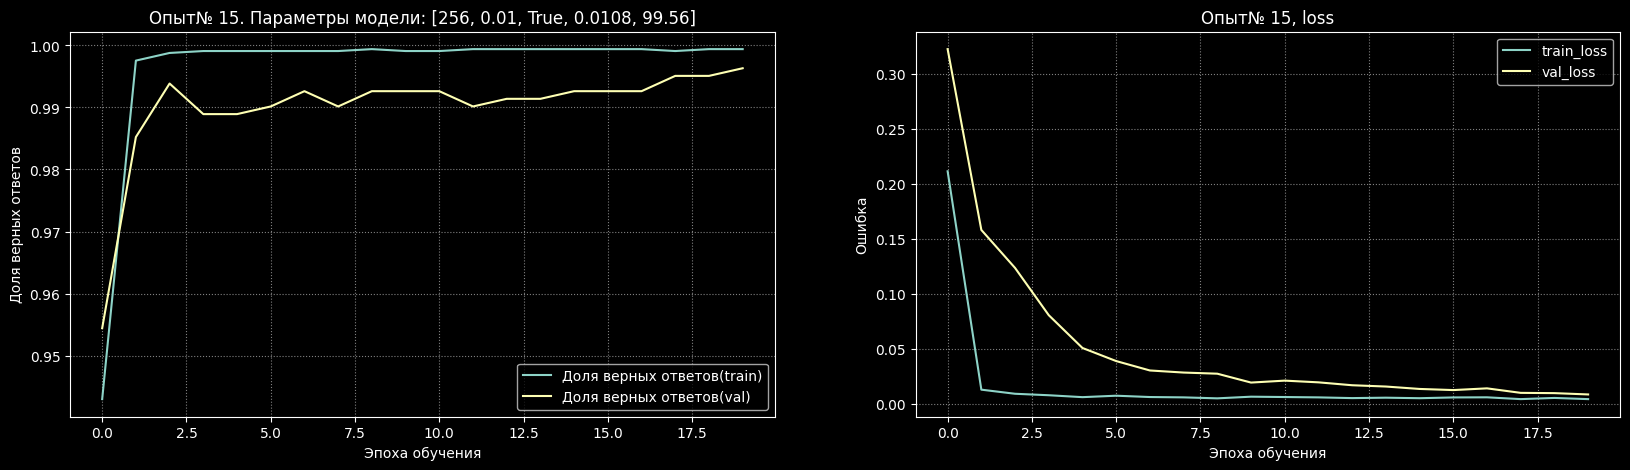

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0124
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



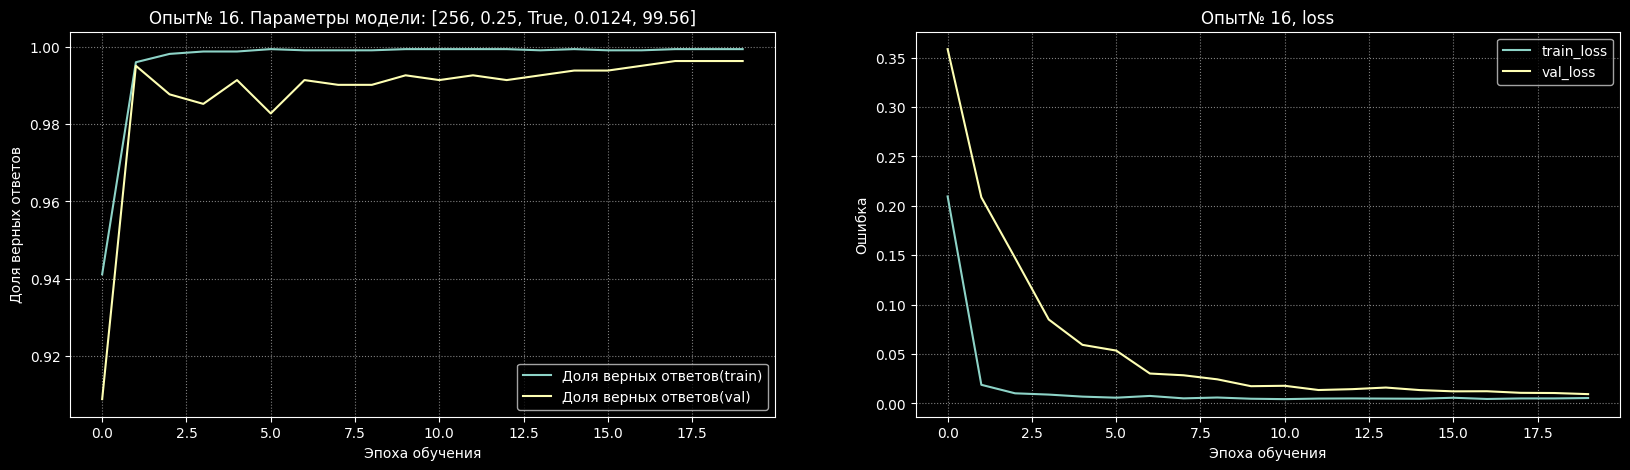

In [ ]:
for exp in range(len(val_loss)):
    graphic(loss[exp], acc[exp], val_loss[exp], val_acc[exp],
            par[exp][-1], par[exp][-2], exp, par[exp])

## Обучение модели с двумя слоями

In [ ]:
par, acc, loss, val_acc, val_loss = training(dense_param, drop_param, norm_param, -2)

Параметры модели: вх.нейр.= 32 ; откл.нейр.= 0.01 ; BatchNormalization= False
Epoch 1/20
26/26 [==============================] - 6s 13ms/step - loss: 0.8654 - accuracy: 0.7693 - val_loss: 0.5223 - val_accuracy: 0.9569
Epoch 2/20
26/26 [==============================] - 0s 5ms/step - loss: 0.3329 - accuracy: 0.9541 - val_loss: 0.1768 - val_accuracy: 0.9581
Epoch 3/20
26/26 [==============================] - 0s 5ms/step - loss: 0.1255 - accuracy: 0.9735 - val_loss: 0.0832 - val_accuracy: 0.9840
Epoch 4/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0630 - accuracy: 0.9923 - val_loss: 0.0497 - val_accuracy: 0.9865
Epoch 5/20
26/26 [==============================] - 0s 5ms/step - loss: 0.0390 - accuracy: 0.9954 - val_loss: 0.0332 - val_accuracy: 0.9951
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0269 - accuracy: 0.9978 - val_loss: 0.0243 - val_accuracy: 0.9963
Epoch 7/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0207 - 

### Сводные результаты обучения

In [ ]:
print('2-й слой нейронов = Вх. слой / 4')
col = [' Число Нейронов ', ' Значение Dropout ',' BatchNormalization? ',' Loss тестовой ', ' Точность тестовой ']
df = pd.DataFrame(par, columns = col, index= np.arange(1, len(par)+1))
df

2-й слой нейронов = Вх. слой / 4


,Число Нейронов,Значение Dropout,BatchNormalization?,Loss тестовой,Точность тестовой
1,32,0.01,False,0.0168,99.33
2,32,0.25,False,0.0091,99.56
3,32,0.01,True,0.0186,98.89
4,32,0.25,True,0.0175,99.11
5,64,0.01,False,0.0169,99.33
6,64,0.25,False,0.0102,99.78
7,64,0.01,True,0.0323,98.89
8,64,0.25,True,0.0233,99.11
9,128,0.01,False,0.0127,99.56
10,128,0.25,False,0.0149,99.56


### Графики обучения

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0168
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



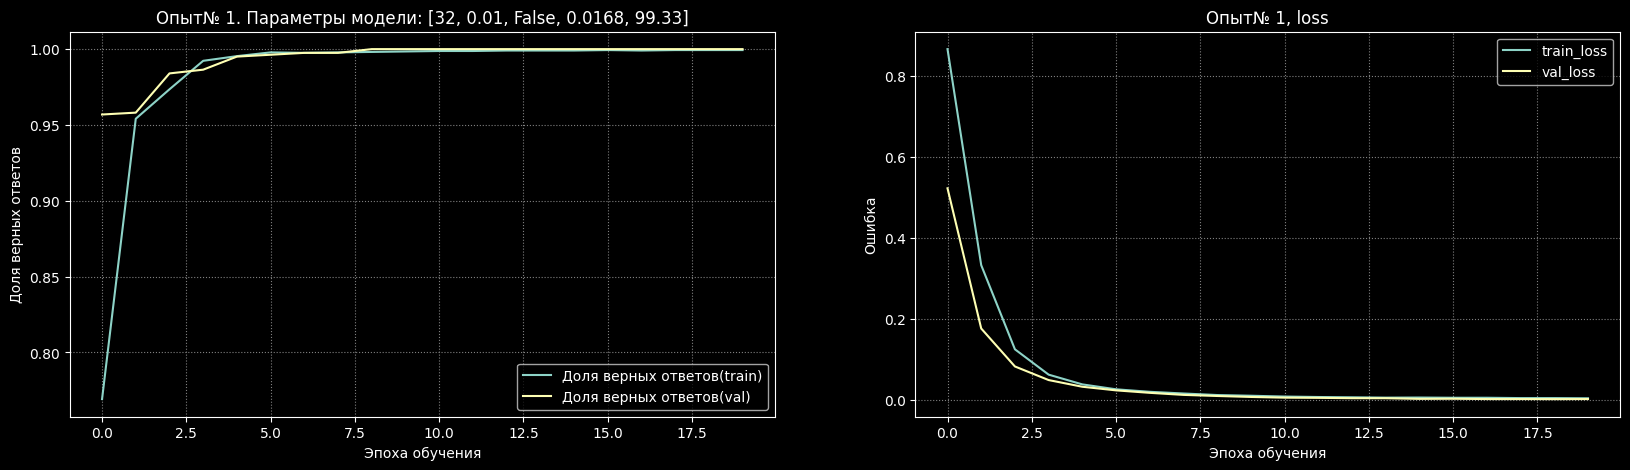

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0091
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



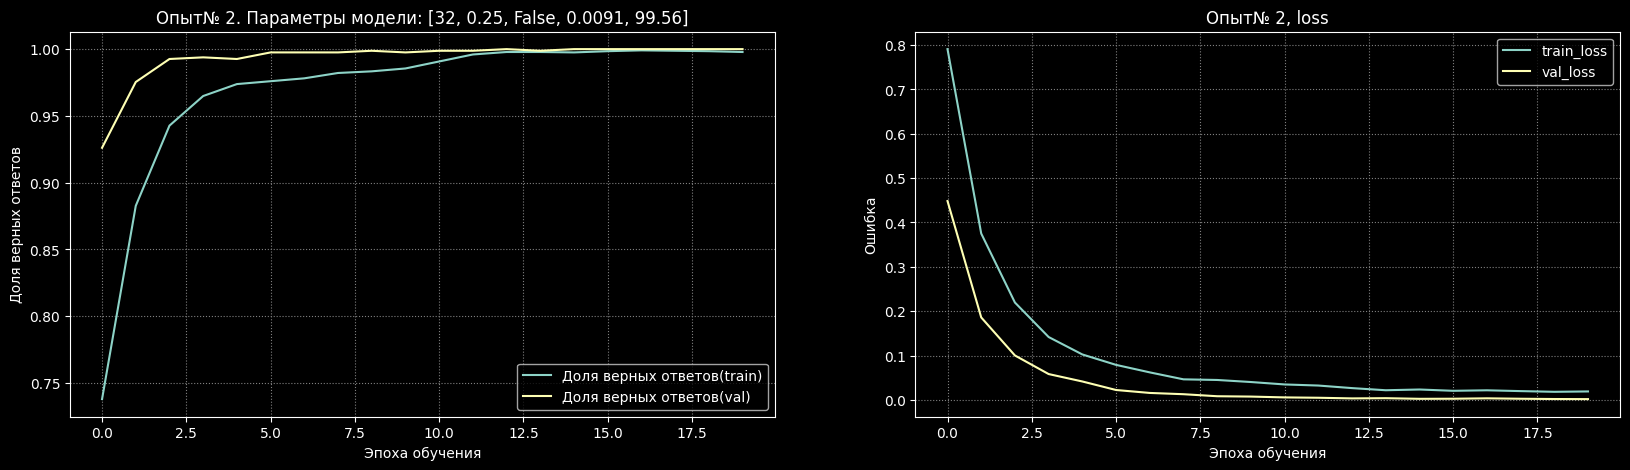

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0186
 Средняя точность на тестовой выборке: 98.89

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



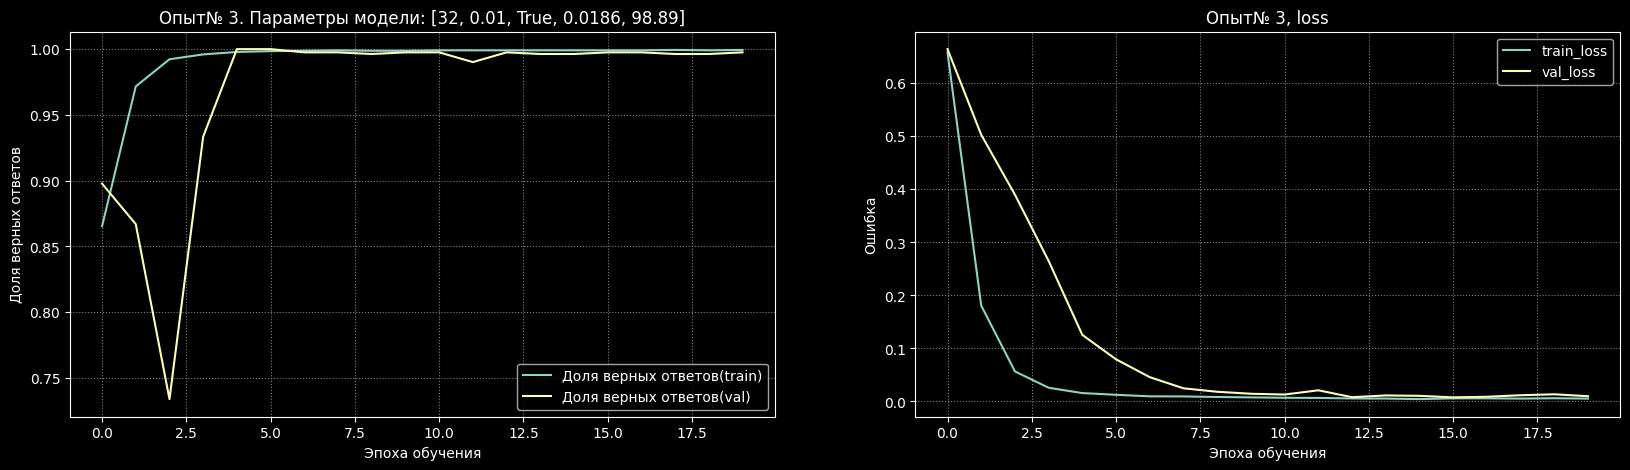

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0175
 Средняя точность на тестовой выборке: 99.11

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



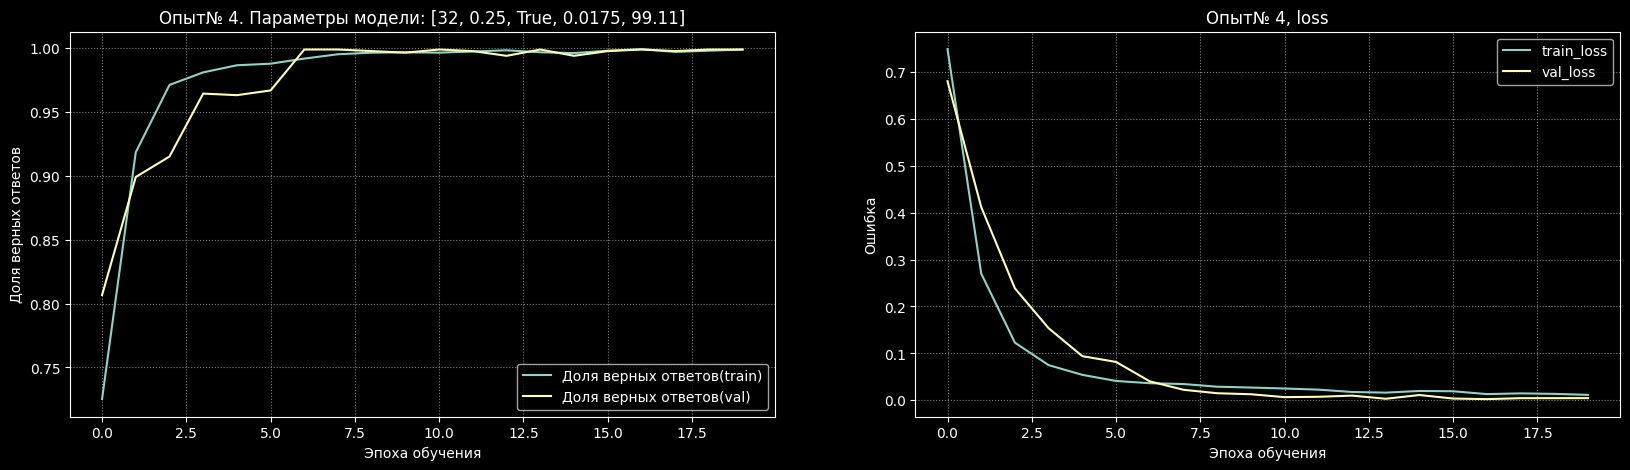

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0169
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



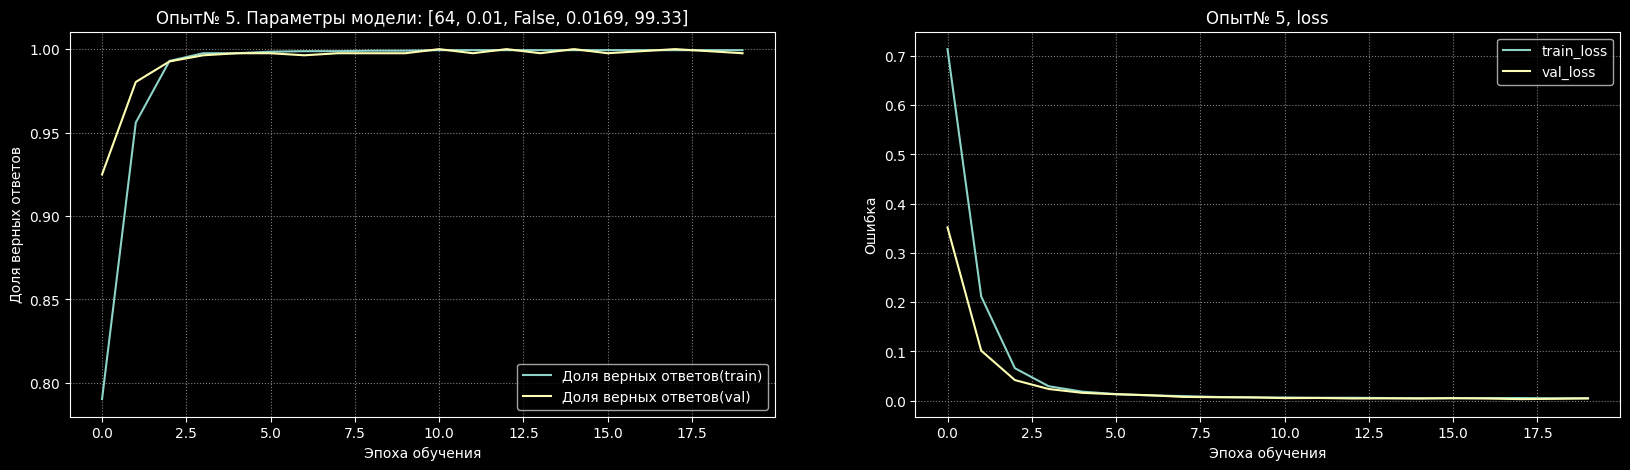

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0102
 Средняя точность на тестовой выборке: 99.78

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



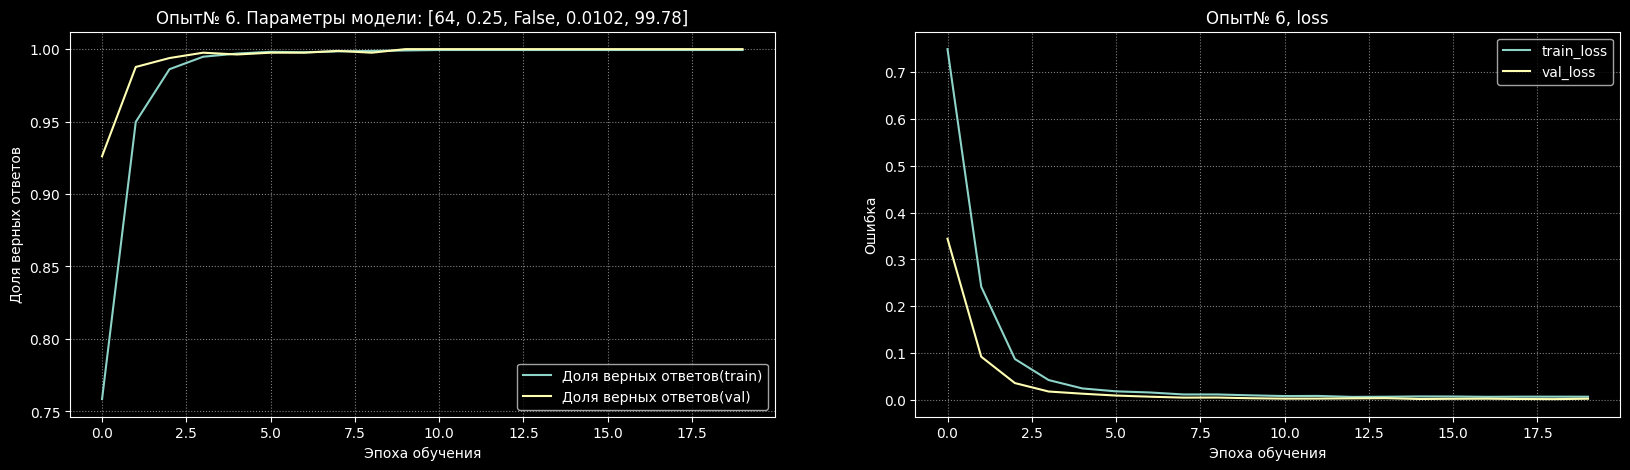

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0323
 Средняя точность на тестовой выборке: 98.89

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



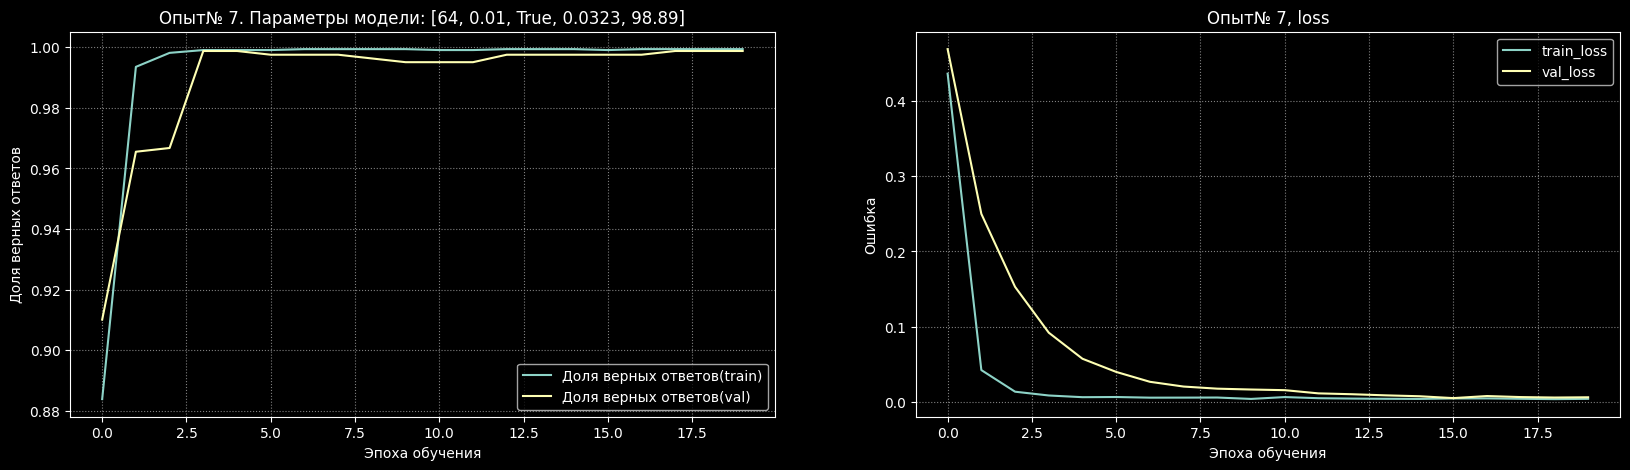

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0233
 Средняя точность на тестовой выборке: 99.11

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



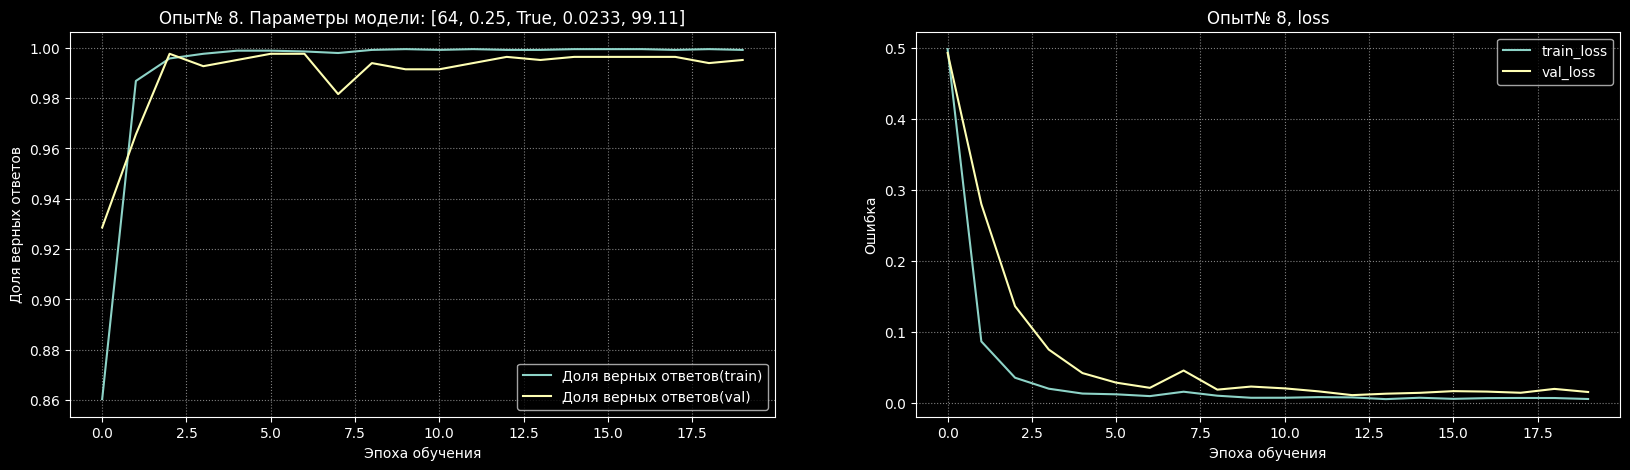

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0127
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



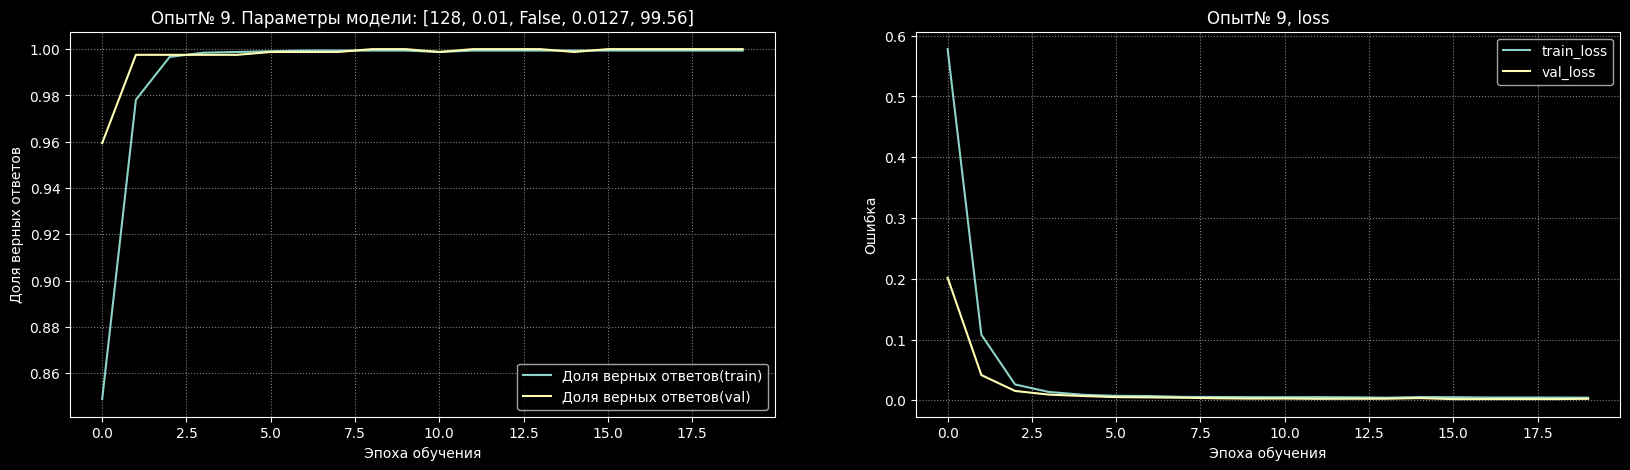

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0149
 Средняя точность на тестовой выборке: 99.56

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



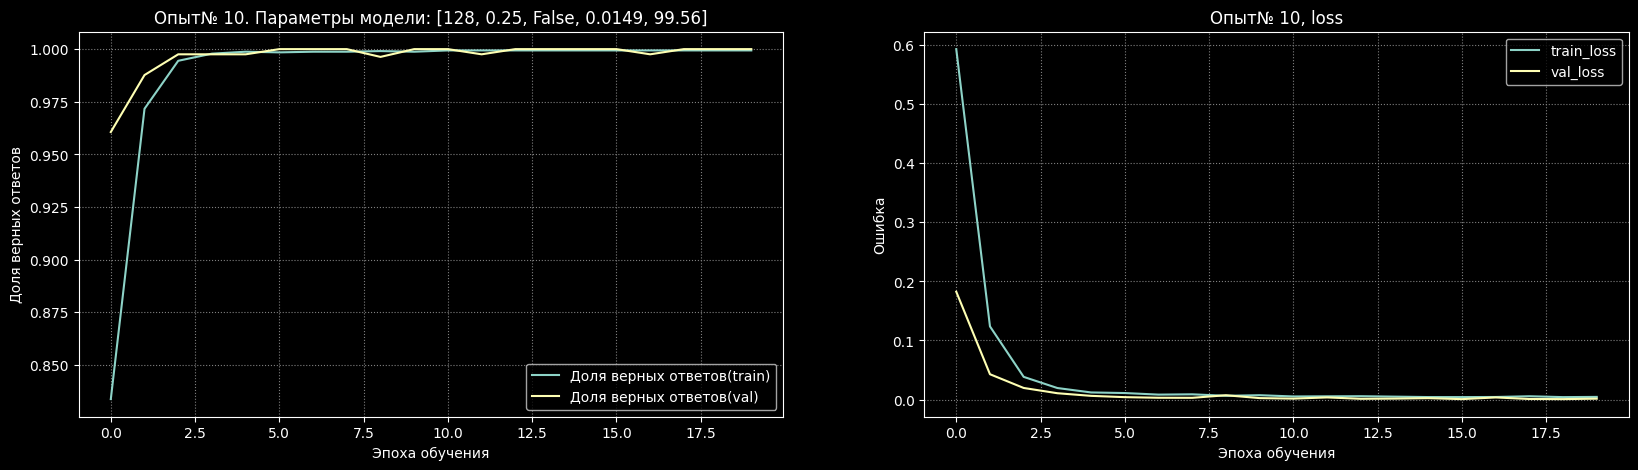

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0139
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



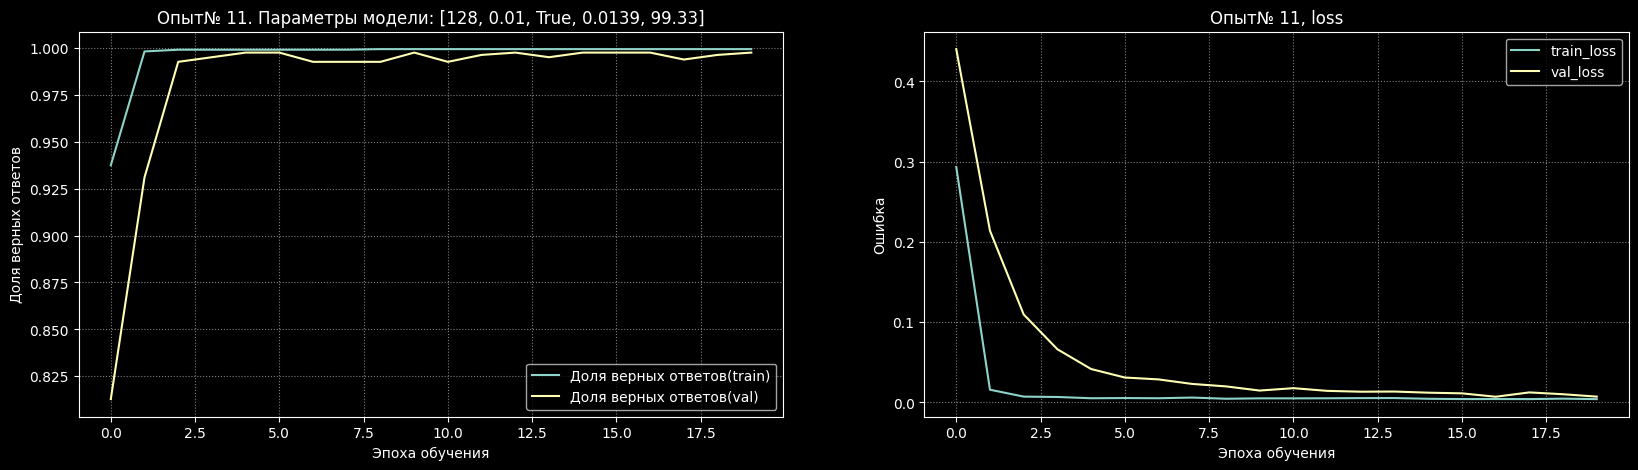

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0163
 Средняя точность на тестовой выборке: 99.33

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



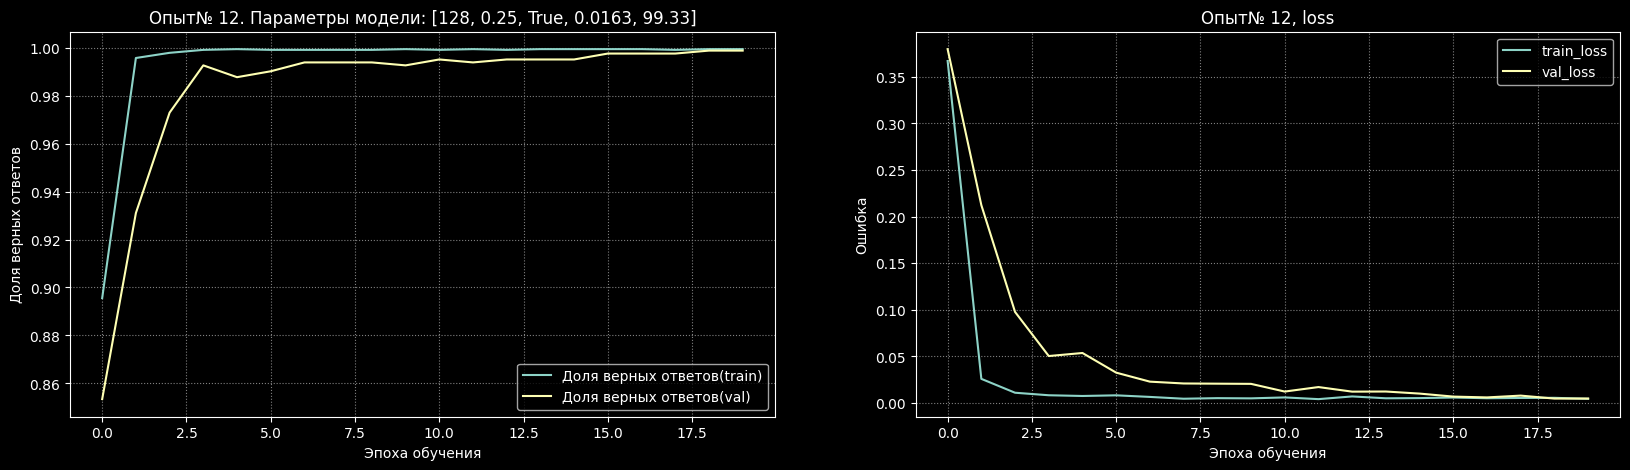

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.0054
 Средняя точность на тестовой выборке: 99.78

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



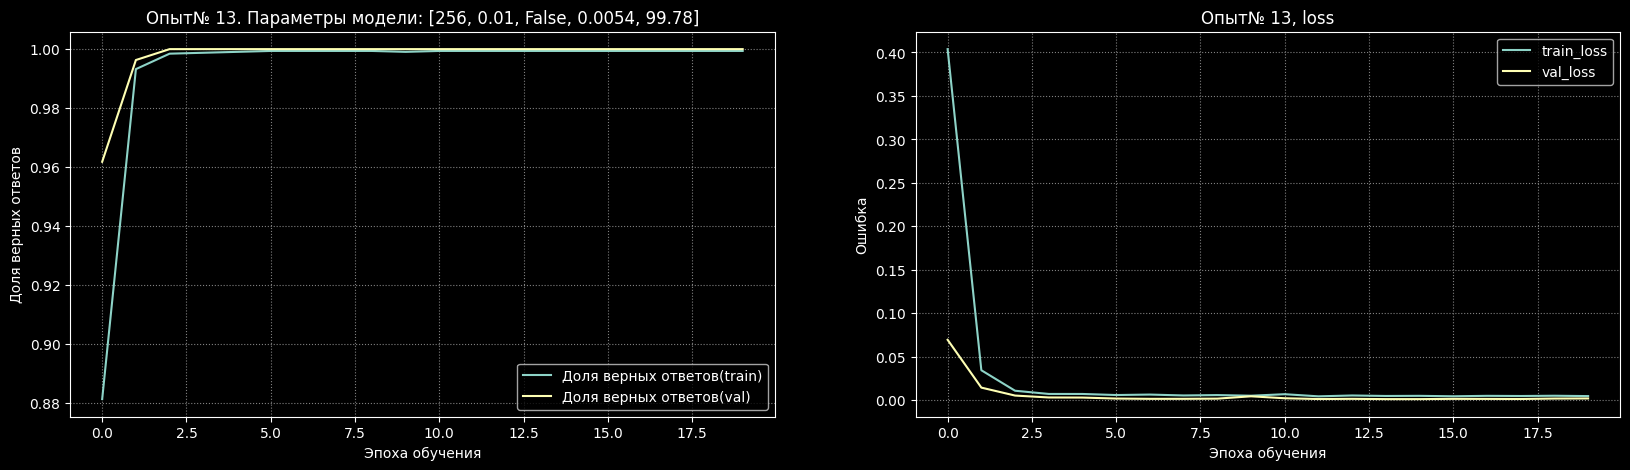

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.0073
 Средняя точность на тестовой выборке: 99.78

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



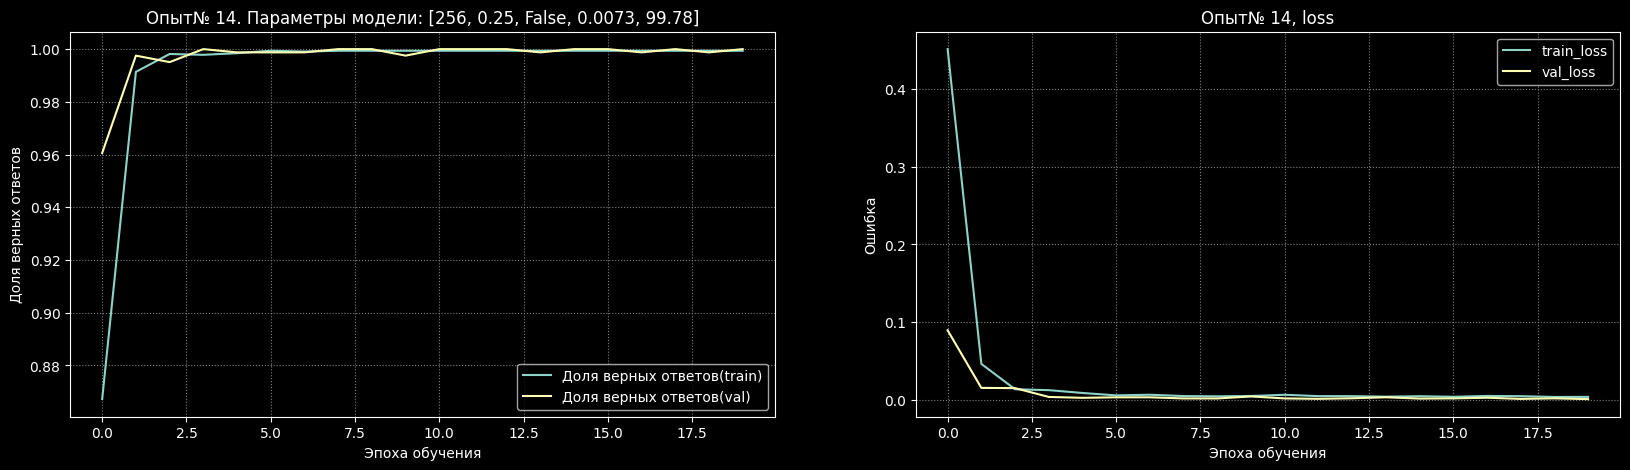

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.0041
 Средняя точность на тестовой выборке: 99.78

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



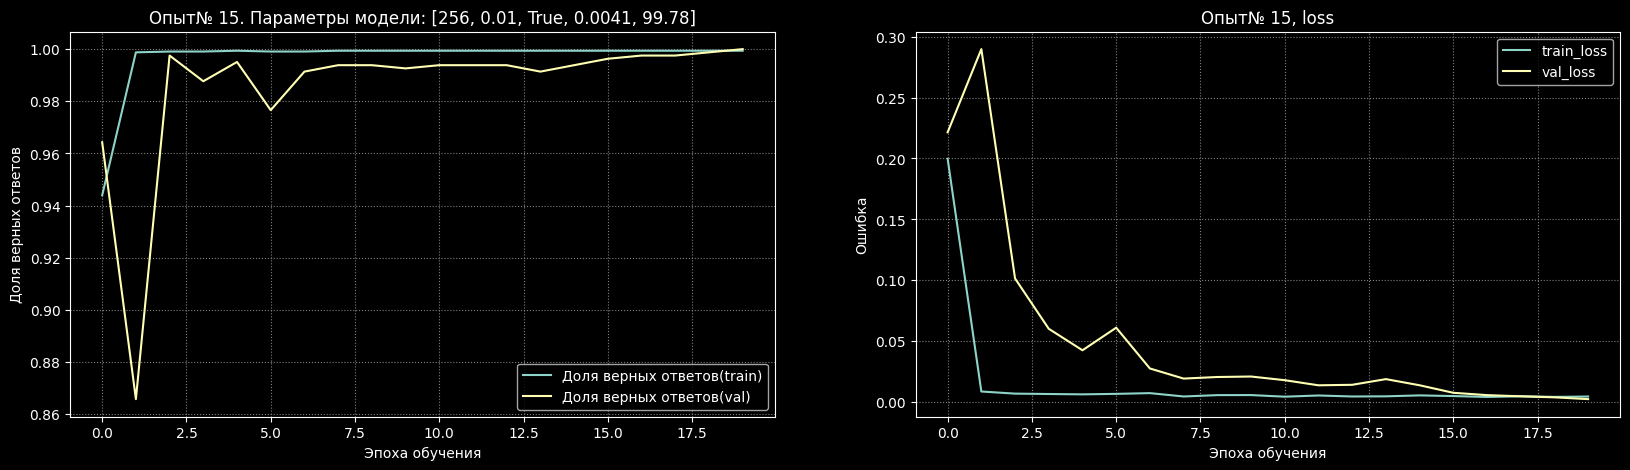

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.0073
 Средняя точность на тестовой выборке: 99.78

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



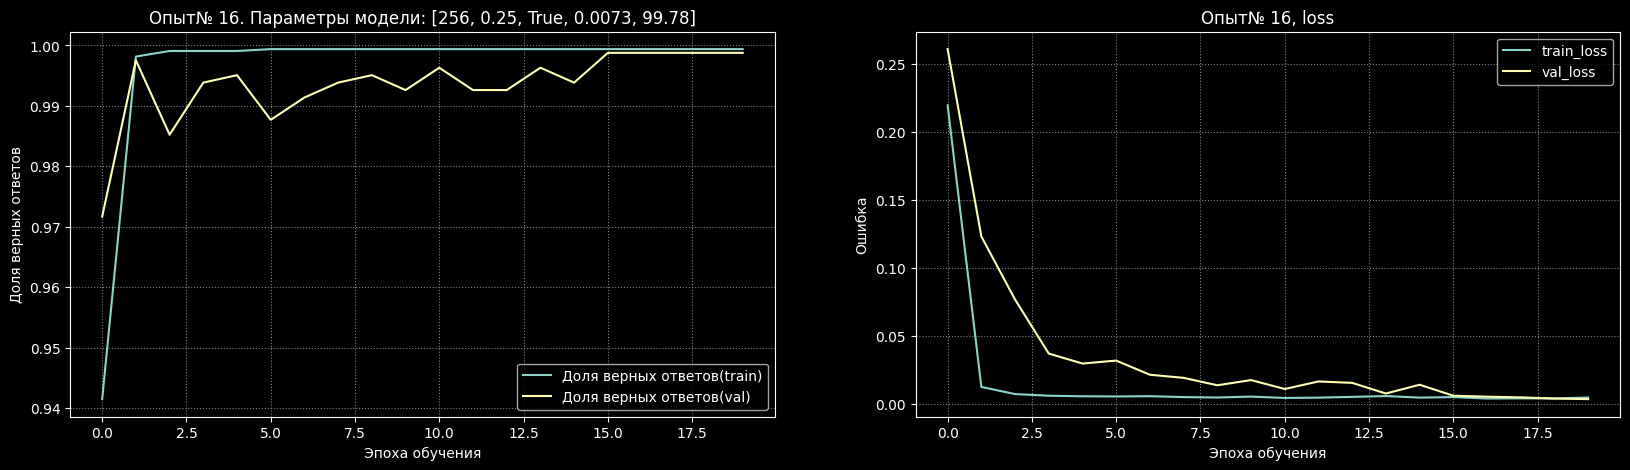

In [ ]:
for exp in range(len(val_loss)):
    graphic(loss[exp], acc[exp], val_loss[exp], val_acc[exp],
            par[exp][-1], par[exp][-2], exp, par[exp])

## Копия. Сводные результаты обучения. 1 слой

,Число Нейронов,Значение Dropout,BatchNormalization?,Loss тестовой,Точность тестовой
1,32,0.01,False,0.0240,98.89
2,32,0.25,False,0.0205,99.33
3,32,0.01,True,0.0172,99.33
4,32,0.25,True,0.0153,99.33
5,64,0.01,False,0.0169,99.56
6,64,0.25,False,0.0140,99.33
7,64,0.01,True,0.0160,99.56
8,64,0.25,True,0.0140,99.33
9,128,0.01,False,0.0118,99.78
10,128,0.25,False,0.0154,99.33


## Копия. Сводные результаты обучения. 2 слоя

2-й слой нейронов = Вх. слой / 4


,Число Нейронов,Значение Dropout,BatchNormalization?,Loss тестовой,Точность тестовой
1,32,0.01,False,0.0168,99.33
2,32,0.25,False,0.0091,99.56
3,32,0.01,True,0.0186,98.89
4,32,0.25,True,0.0175,99.11
5,64,0.01,False,0.0169,99.33
6,64,0.25,False,0.0102,99.78
7,64,0.01,True,0.0323,98.89
8,64,0.25,True,0.0233,99.11
9,128,0.01,False,0.0127,99.56
10,128,0.25,False,0.0149,99.56
